Steps for building a library for DIA(SWATH)

#### 13 Synechocystis Fractions containing ABP protein from Staphylococcus

>HisABP  
GSSHHHHHHSSGLVPRGSHMASLAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYYKNLINNAKTVEGVKALIDEILAALPGTFAHYMDPNSSSVDKLAAA  

ISEATDGLSDFLK  
ELDKYGVSDYYK  
TVEGVKDLQAQVVESAK  
DLQAQVVESAK  
SQTPAEDTVK  
YGVSDYYK  
SQTPAEDTVK  
ALIDEILAALPGTFAHYM(Oxidation)DPNSSSVDK  
GSHM(Oxidation)ASLAEAKVLANRELDK  
SIELAEAK  
NLINNAK  
YGVSDYHKNLINNAK  

* FIRST, Run MSGFPlus and qvality on all searches. But not here

* MAP Alignment and feature extraction. Get RTs of the features with assigned peptides  
    Map alignement of the qvality results using MapAlignerIdentification  
    The transformation coordinates (.trafoXML files) are used to align the mzML files  
    Find features on the rt aligned mzML files with FeatureFinderCentroided  
    Assign identifications to the features: IdMapper  
    Link the features to obtain consensus features: FeatureLinkerUnlabeledQT. The consensus RT is what I want! 

#### READ CONSENSUS FILE WITH CONSENSUS RTs   
Read consensusMap exported by OpenMS FeatureLinkerUnlabeledQT->TextExporter

In [10]:
import os 
import sys
import csv
import pandas
import re
from cStringIO import StringIO
from pyteomics import fasta
from sklearn.linear_model import LinearRegression
import numpy
import matplotlib.pyplot as plt
%matplotlib inline 

In [14]:
#this_dir = 
#consensus_txt = os.path.join(this_dir, "textExporter/consensusMap.csv")'
database = "/home/vitalv/database/Synechocystis_PCC6803_protein_sequences_ABP.fasta"
consensus_txt = "/home/vitalv/cyano_fractionated_20170114/textExporter/consensusMap.csv"


def read_consensus(fn):
	cons_header, pept_header, runs_name = [], [], []
	# fetch the headers for consensus features, unassigned peptides and experiments' names. 
	for row in csv.reader(open(fn), delimiter='\t'):
		if row[0] == '#CONSENSUS':
			cons_header = row
		elif row[0] == '#UNASSIGNEDPEPTIDE':
			pept_header = row
		elif row[0] == 'MAP':
			runs_name.append(row[2].split("/")[-1].split(".")[0])
	# read consensus features
	s = StringIO()
	with open(fn) as fh:
		for line in fh:
			if line.startswith("CONSENSUS"):
				s.write(line)
	s.seek(0)
	cons = pandas.read_csv(s, sep='\t', header=None, names=cons_header)
	co_peps = []
	with open(fn) as fh:
		for line in fh:
			if line.startswith("CONSENSUS"):
				co_peps.append('')
			elif line.startswith('PEPTIDE') and co_peps[-1] == '':
				co_peps[-1] = line.split("\t")[5]# choose the first recorded peptide sequence as consensus sequence
	cons['peptide_0'] = co_peps
	# read uassigned peptides as consensus features
	s = StringIO()
	with open(fn) as fh:
		for line in fh:
			if line.startswith("UNASSIGNEDPEPTIDE"):
				s.write(line)
	s.seek(0)
	ua_peps = pandas.read_csv(s, sep='\t', header=None, names=pept_header)
	ua_peps = ua_peps.groupby(['sequence', 'charge']).mean()

	return cons, ua_peps, runs_name



In [15]:
#Read consensus using the function above
cons, uapep, runs_names = read_consensus(consensus_txt)

#keep only consensus features that do have an assigned peptide sequence:
cons_peps = cons[cons.peptide_0!=""]

#collapse features that have the same peptide assigned to them by selecting the one with the highest feature quality (quality_cf)
cons_peps_groups = cons_peps.groupby('peptide_0', group_keys=False)
cons_peps = cons_peps_groups.apply(lambda x: x.ix[x.quality_cf.idxmax()])

In [16]:
#create new df with the columns I need
pep_df = pandas.DataFrame(columns=['peptide_0', 'charge_cf', 'mz_cf', 'rt_cf', 'base_seq', 'mods', 'uniq', 'accession']) #'peptide'
pep_df['peptide_0'] = [i for i in cons_peps.peptide_0]  + [ i[0] for i in uapep.index.tolist()]
pep_df['charge_cf'] = [i for i in cons_peps.charge_cf]  + [ i[1] for i in uapep.index.tolist()]
pep_df['mz_cf'] = [i for i in cons_peps.mz_cf] + uapep.mz.tolist()
pep_df['rt_cf'] = [i for i in cons_peps.rt_cf] + uapep.rt.tolist()
pep_df['base_seq'] = [ re.sub('\(.+?\)', '', str(i)) for i in pep_df.peptide_0]
pep_df['mods'] = [ sorted(re.findall('\(.+?\)', str(i))) for i in pep_df.peptide_0]
pep_df['uniq'] = [ "%s%d%s" % (x.base_seq, x.charge_cf, ''.join(x.mods)) for i, x in pep_df.iterrows()]


#add the corresponding protein accession
#this takes sooo long, find a quicker way
for i, r in pep_df.iterrows():
	for header, seq in fasta.read(database):
		if r.base_seq in seq:
			pep_df.loc[i,'accession'] = header.split(" ")[0]


In [17]:
#FIND ABP PEPTIDES  
abp_peps = pep_df[pep_df.accession == "HisABP"]

#there are abp peptides repeated. group by sequence and get median rt:
abp_irts = abp_peps.groupby('peptide_0', as_index=False).median().sort_values(by='rt_cf').reset_index(drop=True)


In [18]:
#Create new iRT scale:
cons_peps.rt_cf.min() #650.65
cons_peps.rt_cf.max() #4930.36
abp_irts["iRT"] = ['']*(len(abp_irts))
for i, r in abp_irts.iterrows():
	first_rt_cf = abp_irts.loc[0, 'rt_cf']
	last_rt_cf = abp_irts.loc[len(abp_irts)-1, 'rt_cf']
	if i == 0:
		abp_irts.loc[i, 'iRT'] = 0.0
	elif i == len(abp_irts)-1:
		abp_irts.loc[i, 'iRT'] = 120.0
	else:
		irt = ((r.rt_cf- first_rt_cf )*120.0)/(last_rt_cf-first_rt_cf)
		abp_irts.loc[i, 'iRT'] = irt


In [20]:
#SET a LINEAR REGRESSION MODEL
import numpy
X = numpy.array(abp_irts.rt_cf).reshape(-1,1)
y = numpy.array(abp_irts.iRT)
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

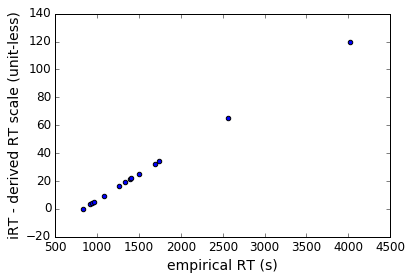

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.scatter(abp_irts.rt_cf, abp_irts.iRT)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("empirical RT (s)", fontsize=14)
plt.ylabel("iRT - derived RT scale (unit-less)", fontsize=14)
plt.show()


#### Read the qvality results to get a RT dataframe for the ABP peptides in each run

In [34]:
import sys
sys.path.append('/home/vitalv/cyano_fractionated_20170114/')
import qvality
#this_dir = os.getcwd()
this_dir = "/home/vitalv/cyano_fractionated_20170114/"
msgfplus_folder = os.path.join(this_dir, "msgfplus/")
qvality_folder = os.path.join(this_dir, "qvality/")


#Read the identification results from the qvality folder (previous to MapAlignerId)


run_abp_peps = {}

for file in [file for file in os.listdir(msgfplus_folder) if file.endswith(".idXML")]:

    msgfp_csv = os.path.join(msgfplus_folder, file.split(".")[0] + ".csv")
    msgfp_idxml = os.path.join(msgfplus_folder, file)

    msgfp_file_basename = os.path.basename(file).split(".")[0]
    run = msgfp_file_basename.split("_")[1]
    msgfp_psms = qvality.read_msgfp_csv(msgfp_csv)
    msgfp_peptides, msgfp_null_peptides = qvality.target_and_null_peptides_4_qvality(msgfp_psms)
    #qvality_out_file = run_qvality(msgfp_file_basename, msgfp_peptides, msgfp_null_peptides)
    qvality_out_file = msgfp_file_basename + "_qvality_out.csv"
    msgfp_qvality = qvality.read_qvality_result(qvality_folder+qvality_out_file)

    msgfp_peptides = msgfp_peptides.sort_values(by='score')
    msgfp_peptides["qval"] = msgfp_qvality["q-value"].values

    msgfp_peptides = msgfp_peptides[msgfp_peptides["qval"]<0.01]
    msgfp_peptides = msgfp_peptides[~msgfp_peptides.accessions.str.contains('XXX')]

    run_abp_peps[run] = msgfp_peptides[msgfp_peptides.accessions == "HisABP"]

    #print "Unique identified peptides by MSGF+ (excluding decoy hits, q-val 0.01) in %s: %s"%(msgfp_file_basename, len(msgfp_peptides))
    #print "Unique proteins those peptides map to: %s"%len(msgfp_peptides.accessions.unique())


for run, abp_peps in run_abp_peps.items():
    abp_peps.rename(columns={'rt': "rt" + "_" + run}, inplace=True)

abp_peps_dfs = [abp_peps.sort_values(by="sequence") for abp_peps in run_abp_peps.values()]

abp_rts = reduce(lambda left,right: pandas.merge(left, right, on='sequence'), abp_peps_dfs)
rt_cols = [col for col in abp_rts.columns if "rt" in col and "predicted" not in col]
abp_rts = abp_rts[['sequence']+ rt_cols]


seq_rt_boxes = {}
for i in range(len(abp_rts)):
    seq_rt_boxes[abp_rts.loc[i, 'sequence']] = list(abp_rts.loc[i, rt_cols])

import operator
sorted_seq_rt_boxes = sorted(seq_rt_boxes.items(), key=operator.itemgetter(1))

#do this if boxes is just the list of rt_lists (not a dict where key is the sequence)
#boxes = boxes.sort(key=lambda x: numpy.median(x))

seqs = [sorted_seq_rt_boxes[i][0] for i in range(len(sorted_seq_rt_boxes))]
boxes_ua = [sorted_seq_rt_boxes[i][1] for i in range(len(sorted_seq_rt_boxes))]


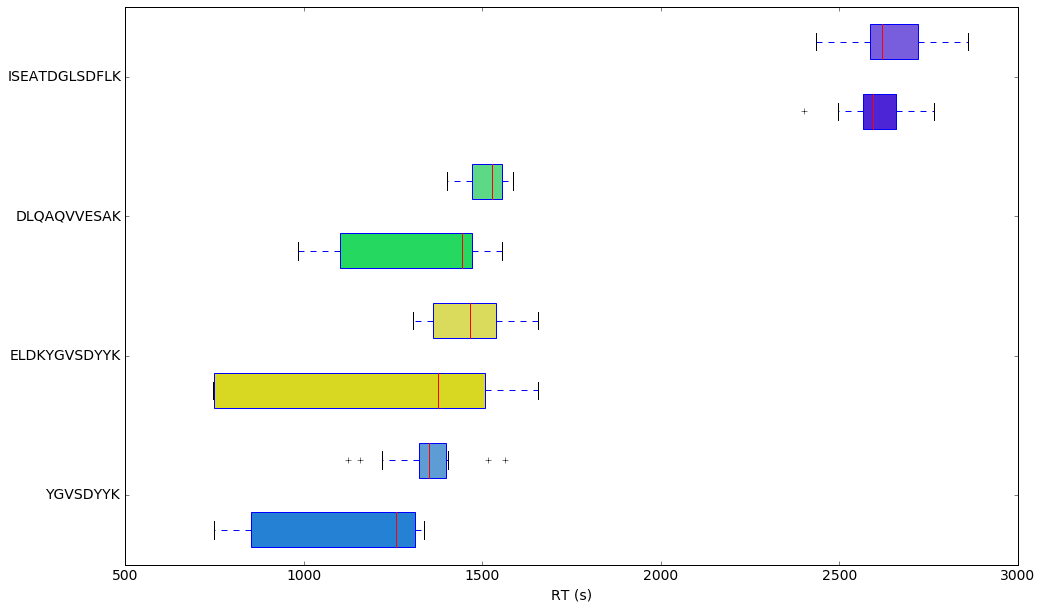

In [35]:
#Same thing for the Aligned (MapAlignerIdentification) results


map_aligner_folder = os.path.join(this_dir, "mapAligner/")

aligned_run_abp_peps = {}

for file in [file for file in os.listdir(map_aligner_folder) if file.endswith(".csv")]:
	run = file.split("_")[1]
	aligned = qvality.read_msgfp_csv(os.path.join(map_aligner_folder, file))
	aligned_run_abp_peps[run] = aligned[aligned.accessions == "HisABP"]	

for run, aligned_abp_peps in aligned_run_abp_peps.items():
	aligned_abp_peps.rename(columns={'rt': "rt" + "_" + run}, inplace=True)


aligned_abp_peps_dfs = [aligned_abp_peps.sort_values(by="sequence") for aligned_abp_peps in aligned_run_abp_peps.values()]

aligned_abp_rts = reduce(lambda left,right: pandas.merge(left, right, on='sequence'), aligned_abp_peps_dfs)

rt_cols = [col for col in aligned_abp_rts.columns if "rt" in col and "predicted" not in col]

aligned_abp_rts = aligned_abp_rts[['sequence']+ rt_cols]

seq_aligned_rt_boxes = {}
for i in range(len(aligned_abp_rts)):
	seq_aligned_rt_boxes[aligned_abp_rts.loc[i, 'sequence']] = list(aligned_abp_rts.loc[i, rt_cols])

sorted_seq_aligned_rt_boxes = sorted(seq_aligned_rt_boxes.items(), key=operator.itemgetter(1))

seqs = [sorted_seq_aligned_rt_boxes[i][0] for i in range(len(sorted_seq_aligned_rt_boxes))]
boxes_a = [sorted_seq_aligned_rt_boxes[i][1] for i in range(len(sorted_seq_aligned_rt_boxes))]

boxes_ = [boxes_ua[0], boxes_a[0], boxes_ua[1], boxes_a[1], boxes_ua[2], boxes_a[2], boxes_ua[3], boxes_a[3]]

fig, ax = plt.subplots(1, figsize=(16,10))

bplot = ax.boxplot(boxes_, vert=False, patch_artist=True)
bplot['boxes'][0].set_facecolor("#2581D3")
bplot['boxes'][1].set_facecolor("#5D9CD5")
bplot['boxes'][2].set_facecolor("#D8D822")
bplot['boxes'][3].set_facecolor("#DADA5C")
bplot['boxes'][4].set_facecolor("#24D860")
bplot['boxes'][5].set_facecolor("#5CD886")
bplot['boxes'][6].set_facecolor("#4C26D6")
bplot['boxes'][7].set_facecolor("#785DDC")
plt.yticks([1.5,3.5,5.5,7.5], seqs, rotation='horizontal', fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('RT (s)', fontsize=14)
plt.show()
